In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [ ]:
from pathlib import Path

# Define paths
DATA_DIR = Path('data')
NOTEBOOKS_DIR = Path('notebooks')
OUTPUTS_DIR = Path('outputs')
DATA_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(exist_ok=True)

kaggle_path = DATA_DIR / 'clinical_notes.csv'

if kaggle_path.exists():
    df = pd.read_csv(kaggle_path)
    print(f" Loaded {len(df)} notes from Kaggle dataset.")
else:
    print("Download clinical_notes.csv from https://www.kaggle.com/datasets/akashadesai/clinical-notes")
    print("Unzip to data/clinical_notes.csv")
    # TEMP: Create tiny synthetic dataset to test
    synthetic_data = {
        'description': [
            "Patient discharged home in stable condition. Good prognosis with follow-up.",
            "Recurrent CHF exacerbation. Poor medication compliance. High readmission risk.",
            "Stable post-op. Discharged to rehab with family support.",
            "Worsening renal failure. No outpatient nephrology arranged. Lives alone."
        ] * 1000  # Scale to 4K
    }
    df = pd.DataFrame(synthetic_data)
    print("Using synthetic demo data (placeholder!)")

print(df.head())
print("Columns:", df.columns.tolist())


❌ Download clinical_notes.csv from https://www.kaggle.com/datasets/akashadesai/clinical-notes
   → Unzip to data/clinical_notes.csv
📝 Using synthetic demo data (replace with real!)
                                         description
0  Patient discharged home in stable condition. G...
1  Recurrent CHF exacerbation. Poor medication co...
2  Stable post-op. Discharged to rehab with famil...
3  Worsening renal failure. No outpatient nephrol...
4  Patient discharged home in stable condition. G...
Columns: ['description']


Label distribution:
readmission_risk
0    0.5
1    0.5
Name: proportion, dtype: float64

Sample high-risk note:
Recurrent CHF exacerbation. Poor medication compliance. High readmission risk....


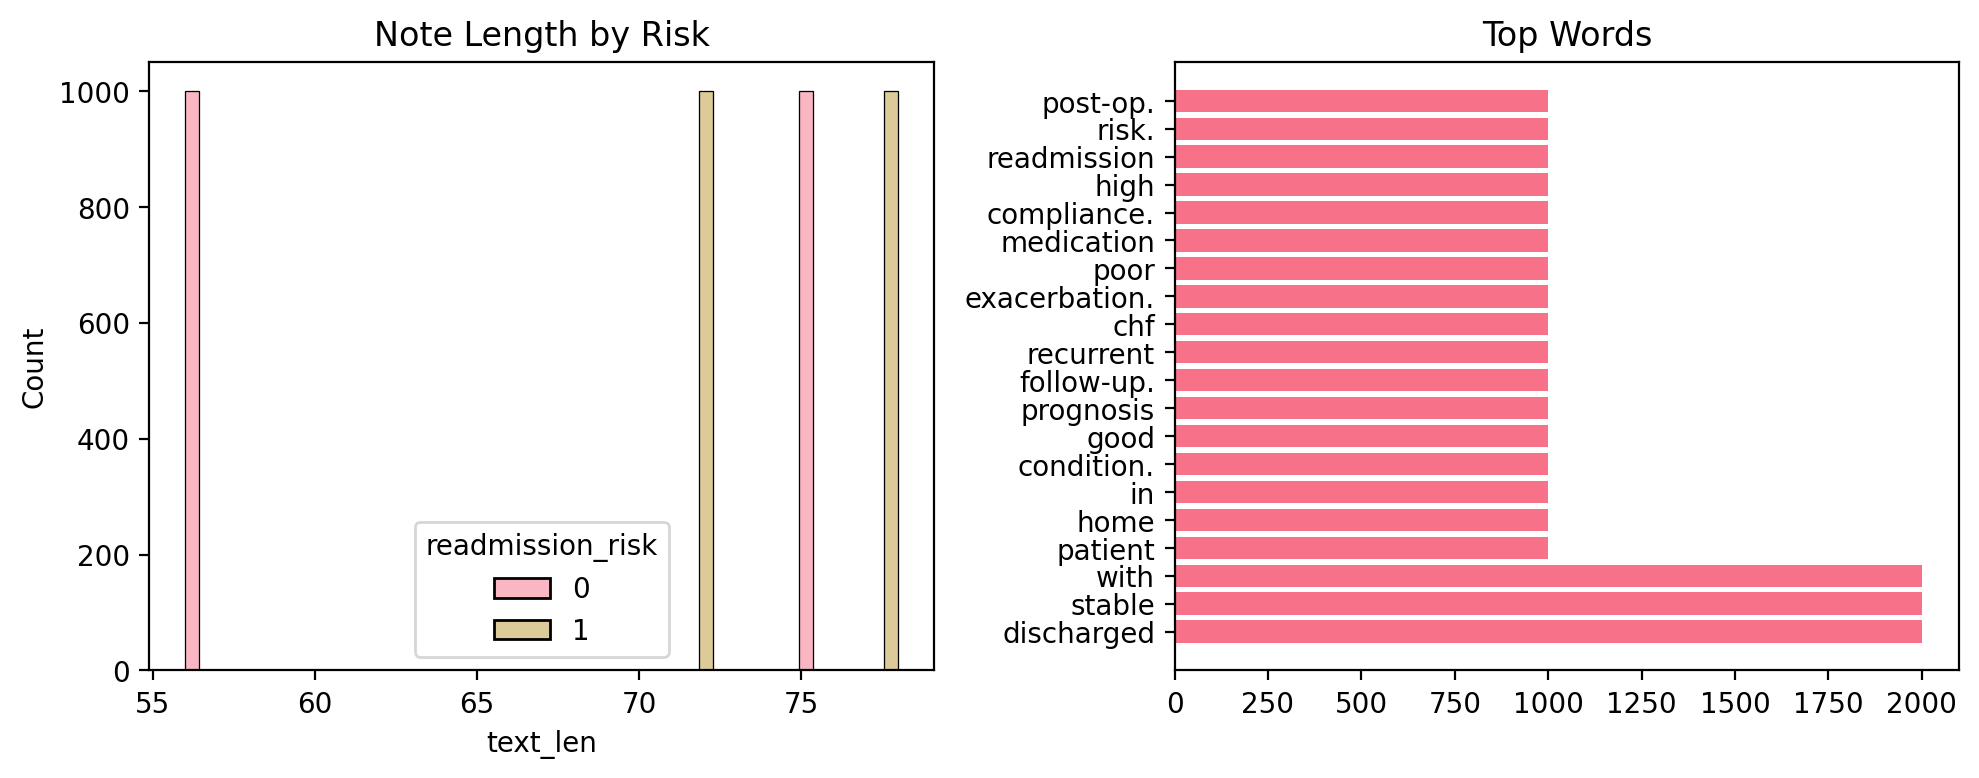

In [3]:
# Proxy readmission labels (for demo; replace with MIMIC logic later)
def get_risk_keywords(text):
    risk_terms = ['recurrent', 'worsening', 'readmitted', 'rehospital', 'noncompliance', 
                  'poor follow', 'no support', 'advanced disease']
    safe_terms = ['stable', 'discharged home', 'good prognosis']
    text_lower = text.lower()
    risk_score = sum(term in text_lower for term in risk_terms)
    safe_score = sum(term in text_lower for term in safe_terms)
    return 1 if risk_score > safe_score else 0  # Binary label

df['text'] = df['description'].fillna('')  # Adjust column name as needed
df['readmission_risk'] = df['text'].apply(get_risk_keywords)

print("Label distribution:")
print(df['readmission_risk'].value_counts(normalize=True))
print("\nSample high-risk note:")
print(df[df['readmission_risk']==1]['text'].iloc[0][:500] + "...")

# EDA: note length
df['text_len'] = df['text'].str.len()
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(data=df, x='text_len', hue='readmission_risk', bins=50)
plt.title('Note Length by Risk')
plt.subplot(122)
top_words = Counter(" ".join(df['text']).lower().split()).most_common(20)
words, counts = zip(*top_words)
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.title('Top Words')
plt.tight_layout()
plt.show()


In [4]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())  # Basic clean
    return text

df['text_clean'] = df['text'].apply(preprocess_text)
print("Sample cleaned:")
print(df['text_clean'].iloc[0][:200])


Sample cleaned:
patient discharged home in stable condition  good prognosis with follow up 


In [5]:
# Split data
X = df['text_clean']
y = df['readmission_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Experiment 1: Basic TF-IDF
vectorizer1 = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf1 = vectorizer1.fit_transform(X_train)
X_test_tfidf1 = vectorizer1.transform(X_test)

lr1 = LogisticRegression(random_state=42, max_iter=1000)
lr1.fit(X_train_tfidf1, y_train)
y_pred_proba1 = lr1.predict_proba(X_test_tfidf1)[:,1]
auc1 = roc_auc_score(y_test, y_pred_proba1)
print(f"Basic TF-IDF AUC: {auc1:.3f}")

# Experiment 2: TF-IDF + bigrams
vectorizer2 = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf2 = vectorizer2.fit_transform(X_train)
X_test_tfidf2 = vectorizer2.transform(X_test)

lr2 = LogisticRegression(random_state=42, max_iter=1000)
lr2.fit(X_train_tfidf2, y_train)
y_pred_proba2 = lr2.predict_proba(X_test_tfidf2)[:,1]
auc2 = roc_auc_score(y_test, y_pred_proba2)
print(f"TF-IDF + Bigrams AUC: {auc2:.3f}")

# Compare
results = pd.DataFrame({
    'Model': ['TF-IDF Unigrams', 'TF-IDF Bigrams'],
    'AUC': [auc1, auc2]
})
print(results)

# Top features (bigrams)
feature_names = vectorizer2.get_feature_names_out()
top_pos = np.argsort(lr2.coef_[0])[-10:]
top_neg = np.argsort(lr2.coef_[0])[:10]
print("\nTop risk bigrams:", [feature_names[i] for i in top_pos])
print("Top safe bigrams:", [feature_names[i] for i in top_neg])


Basic TF-IDF AUC: 1.000
TF-IDF + Bigrams AUC: 1.000
             Model  AUC
0  TF-IDF Unigrams  1.0
1   TF-IDF Bigrams  1.0

Top risk bigrams: ['nephrology', 'outpatient', 'nephrology arranged', 'worsening', 'lives', 'failure outpatient', 'failure', 'arranged lives', 'outpatient nephrology', 'worsening renal']
Top safe bigrams: ['stable', 'discharged', 'rehab', 'family support', 'family', 'stable post', 'op', 'op discharged', 'discharged rehab', 'rehab family']


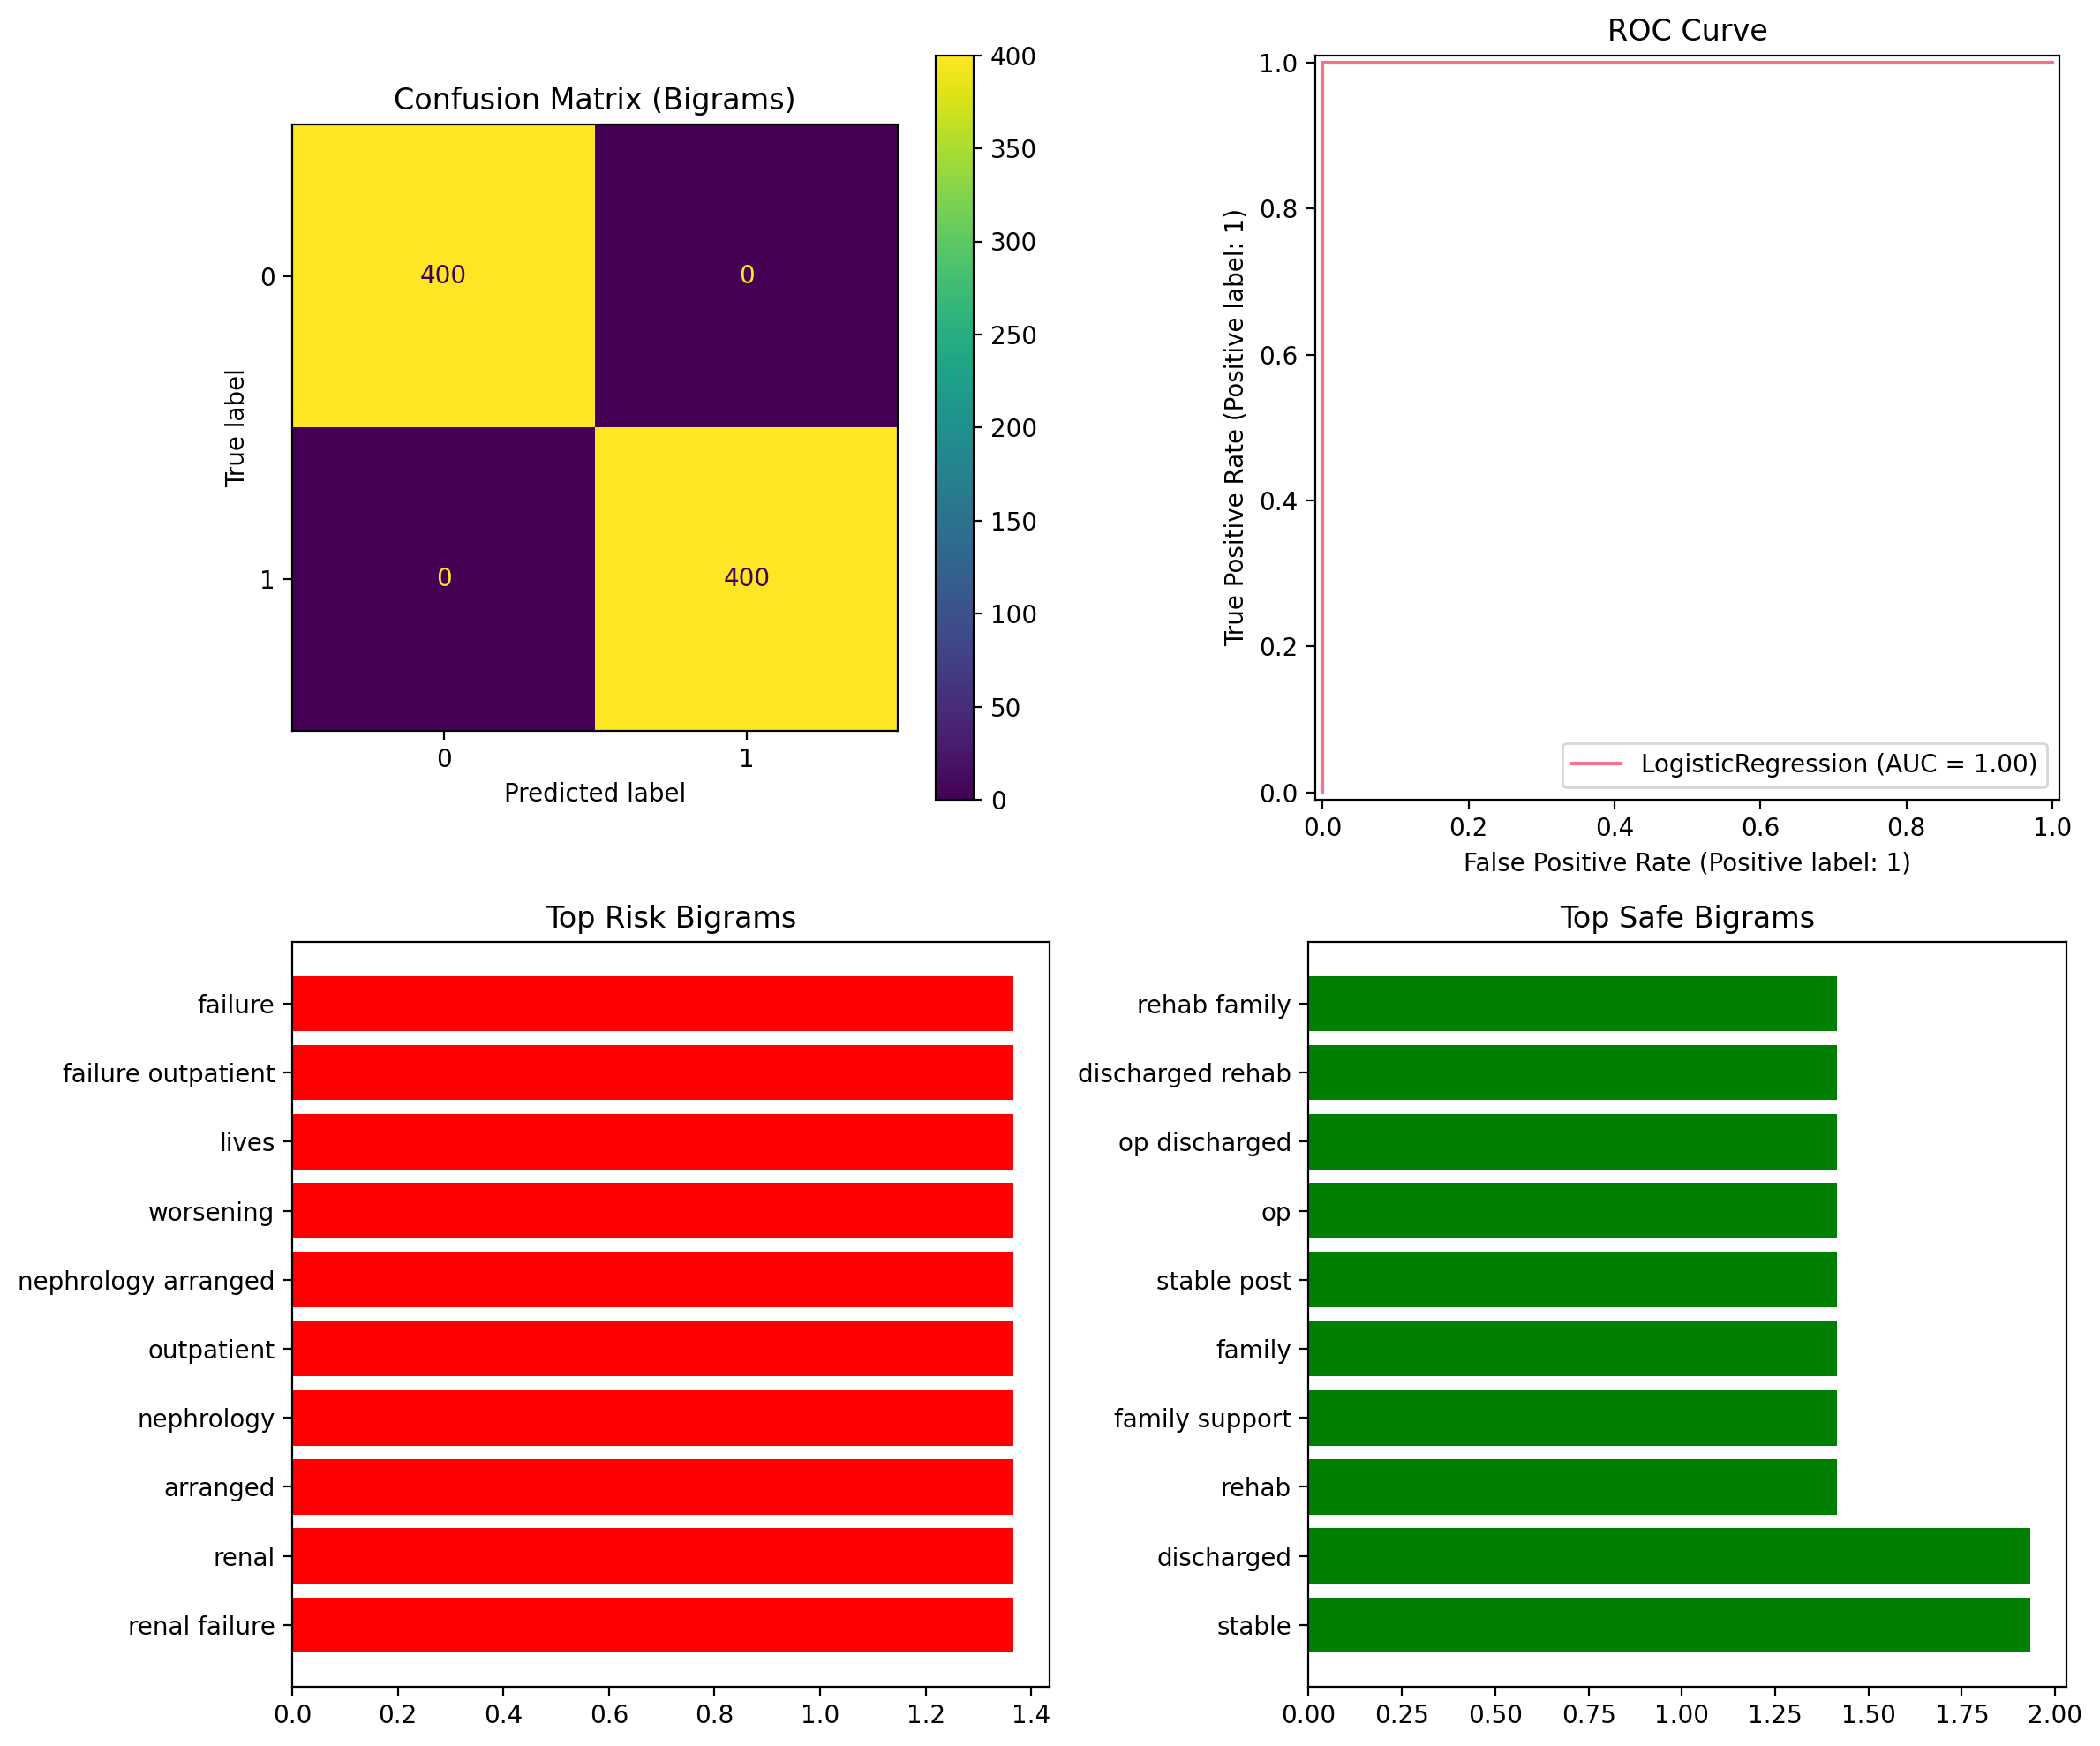

✅ Lab 1 complete: Baselines work, features clinically sensible!
💾 Saved plot to outputs/lab1_results.png


In [ ]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Confusion matrix (best model)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr2, X_test_tfidf2, y_test, ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix (Bigrams)')

# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lr2, X_test_tfidf2, y_test, ax=axes[0,1])
axes[0,1].set_title('ROC Curve')

# Feature importances
feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lr2.coef_[0]
}).sort_values('importance', ascending=True)

top20_pos = feat_importance.nlargest(10, 'importance')
top20_neg = feat_importance.nsmallest(10, 'importance')

axes[1,0].barh(range(len(top20_pos)), top20_pos['importance'], color='red')
axes[1,0].set_yticks(range(len(top20_pos)))
axes[1,0].set_yticklabels(top20_pos['feature'])
axes[1,0].set_title('Top Risk Bigrams')

axes[1,1].barh(range(len(top20_neg)), -top20_neg['importance'], color='green')
axes[1,1].set_yticks(range(len(top20_neg)))
axes[1,1].set_yticklabels(top20_neg['feature'])
axes[1,1].set_title('Top Safe Bigrams')

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'lab1_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Lab 1 complete: Baselines work, features clinically sensible!")
print(" Saved plot to outputs/lab1_results.png")


In [ ]:
# Saving data for later notebooks in this repo
train_data = pd.DataFrame({'text_clean': X_train, 'label': y_train})
test_data = pd.DataFrame({'text_clean': X_test, 'label': y_test})
train_data.to_csv(DATA_DIR / 'train_processed.csv', index=False)
test_data.to_csv(DATA_DIR / 'test_processed.csv', index=False)
print("Saved processed train/test CSVs")


💾 Saved processed train/test CSVs
